### Exploring ECG signals

- work with wfdb to visualize ecg signals and detect QRS complexes
- generate spectograms and scalograms
- encoding time series for deep learning
- build noisy signals
- build train/test set

Imports... If you are missing them, use
-  %pip install library1 library2 .. 

In [4]:
import torch
import torchaudio 
import wfdb
import os
import sys
import wfdb
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import stft
from wfdb import processing

print('Virtual Environment:')
print(sys.prefix)


Virtual Environment:
c:\Users\Pie\Desktop\Thesis\code\signal-denoising\.venv


#### Load ECG signals with WFDB and detect QRS complexes

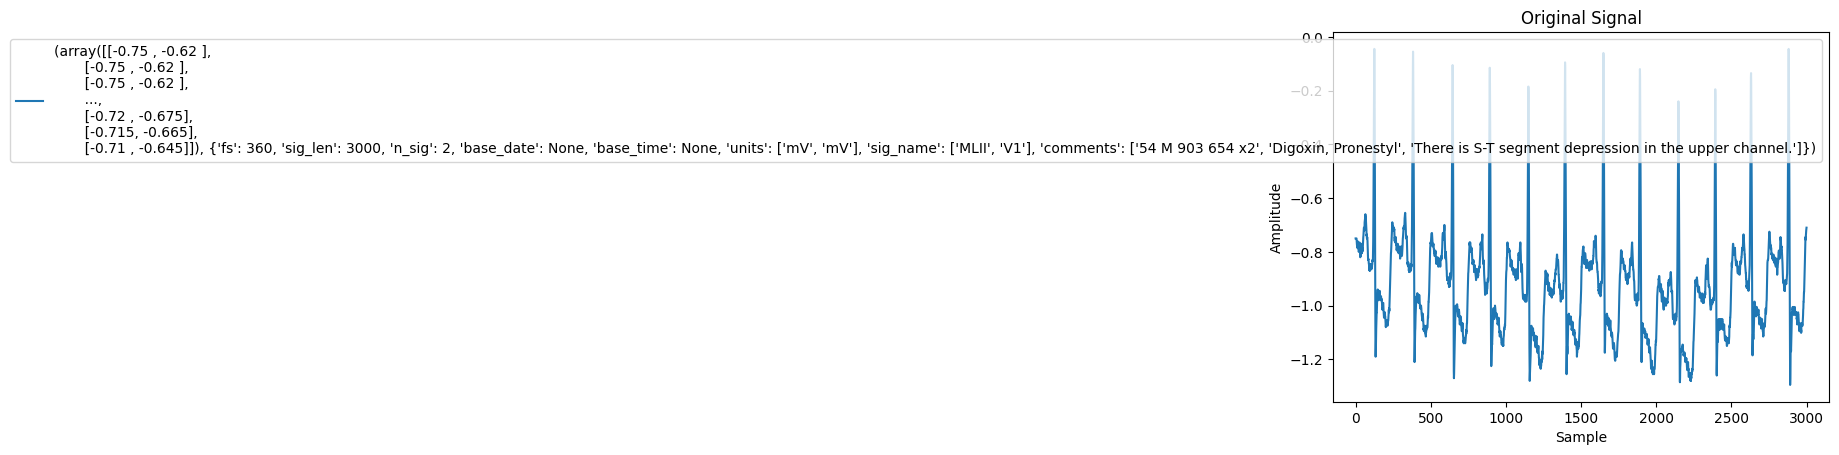

In [5]:
# Path to individual ecg file
# path_102 = "data/nstdb/118e06"
path_102 = "data/ardb/112"

# Extract record
record_102 = wfdb.rdsamp(path_102, sampto=3000)

# Extract Lead I ECG signal
signal_102 = record_102[0][:, 0]

plt.plot(signal_102, label=str(record_102))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Original Signal')
plt.legend()
plt.show()

We proceed to extract the QRS complexes, we can use this to create windows to later build the spectograms.

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


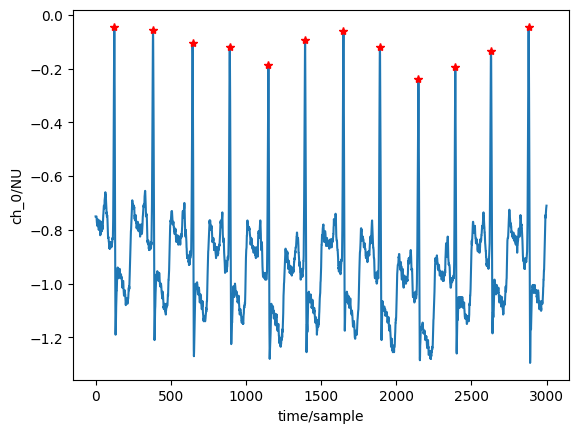

[ 124  382  645  893 1149 1393 1648 1891 2147 2392 2630 2880]


In [6]:
import wfdb
from wfdb import processing

# Load the ECG signal
path_102 = "data/ardb/112"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Plot the signal with QRS complex annotations
wfdb.plot_items(signal=sig, ann_samp=[xqrs.qrs_inds])

print(xqrs.qrs_inds)


We can proceed and extract individual heartbeats based on the QRS complexes it is able to find.

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


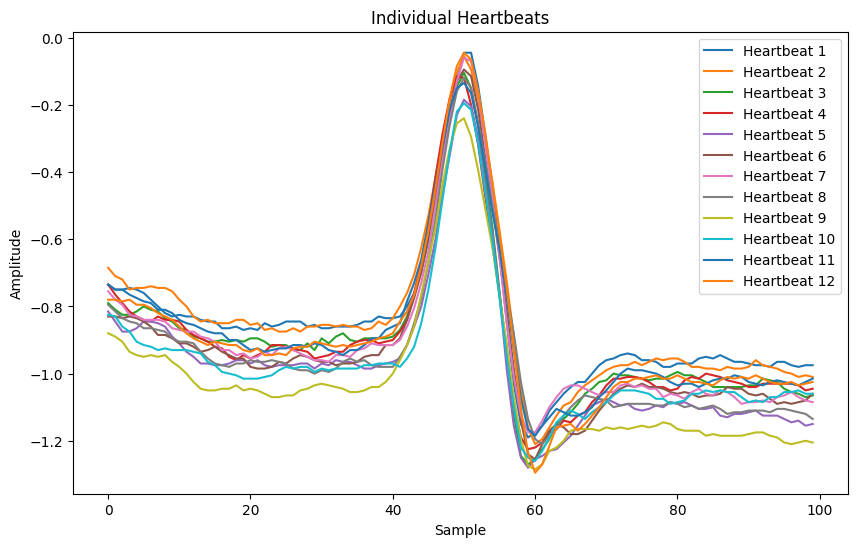

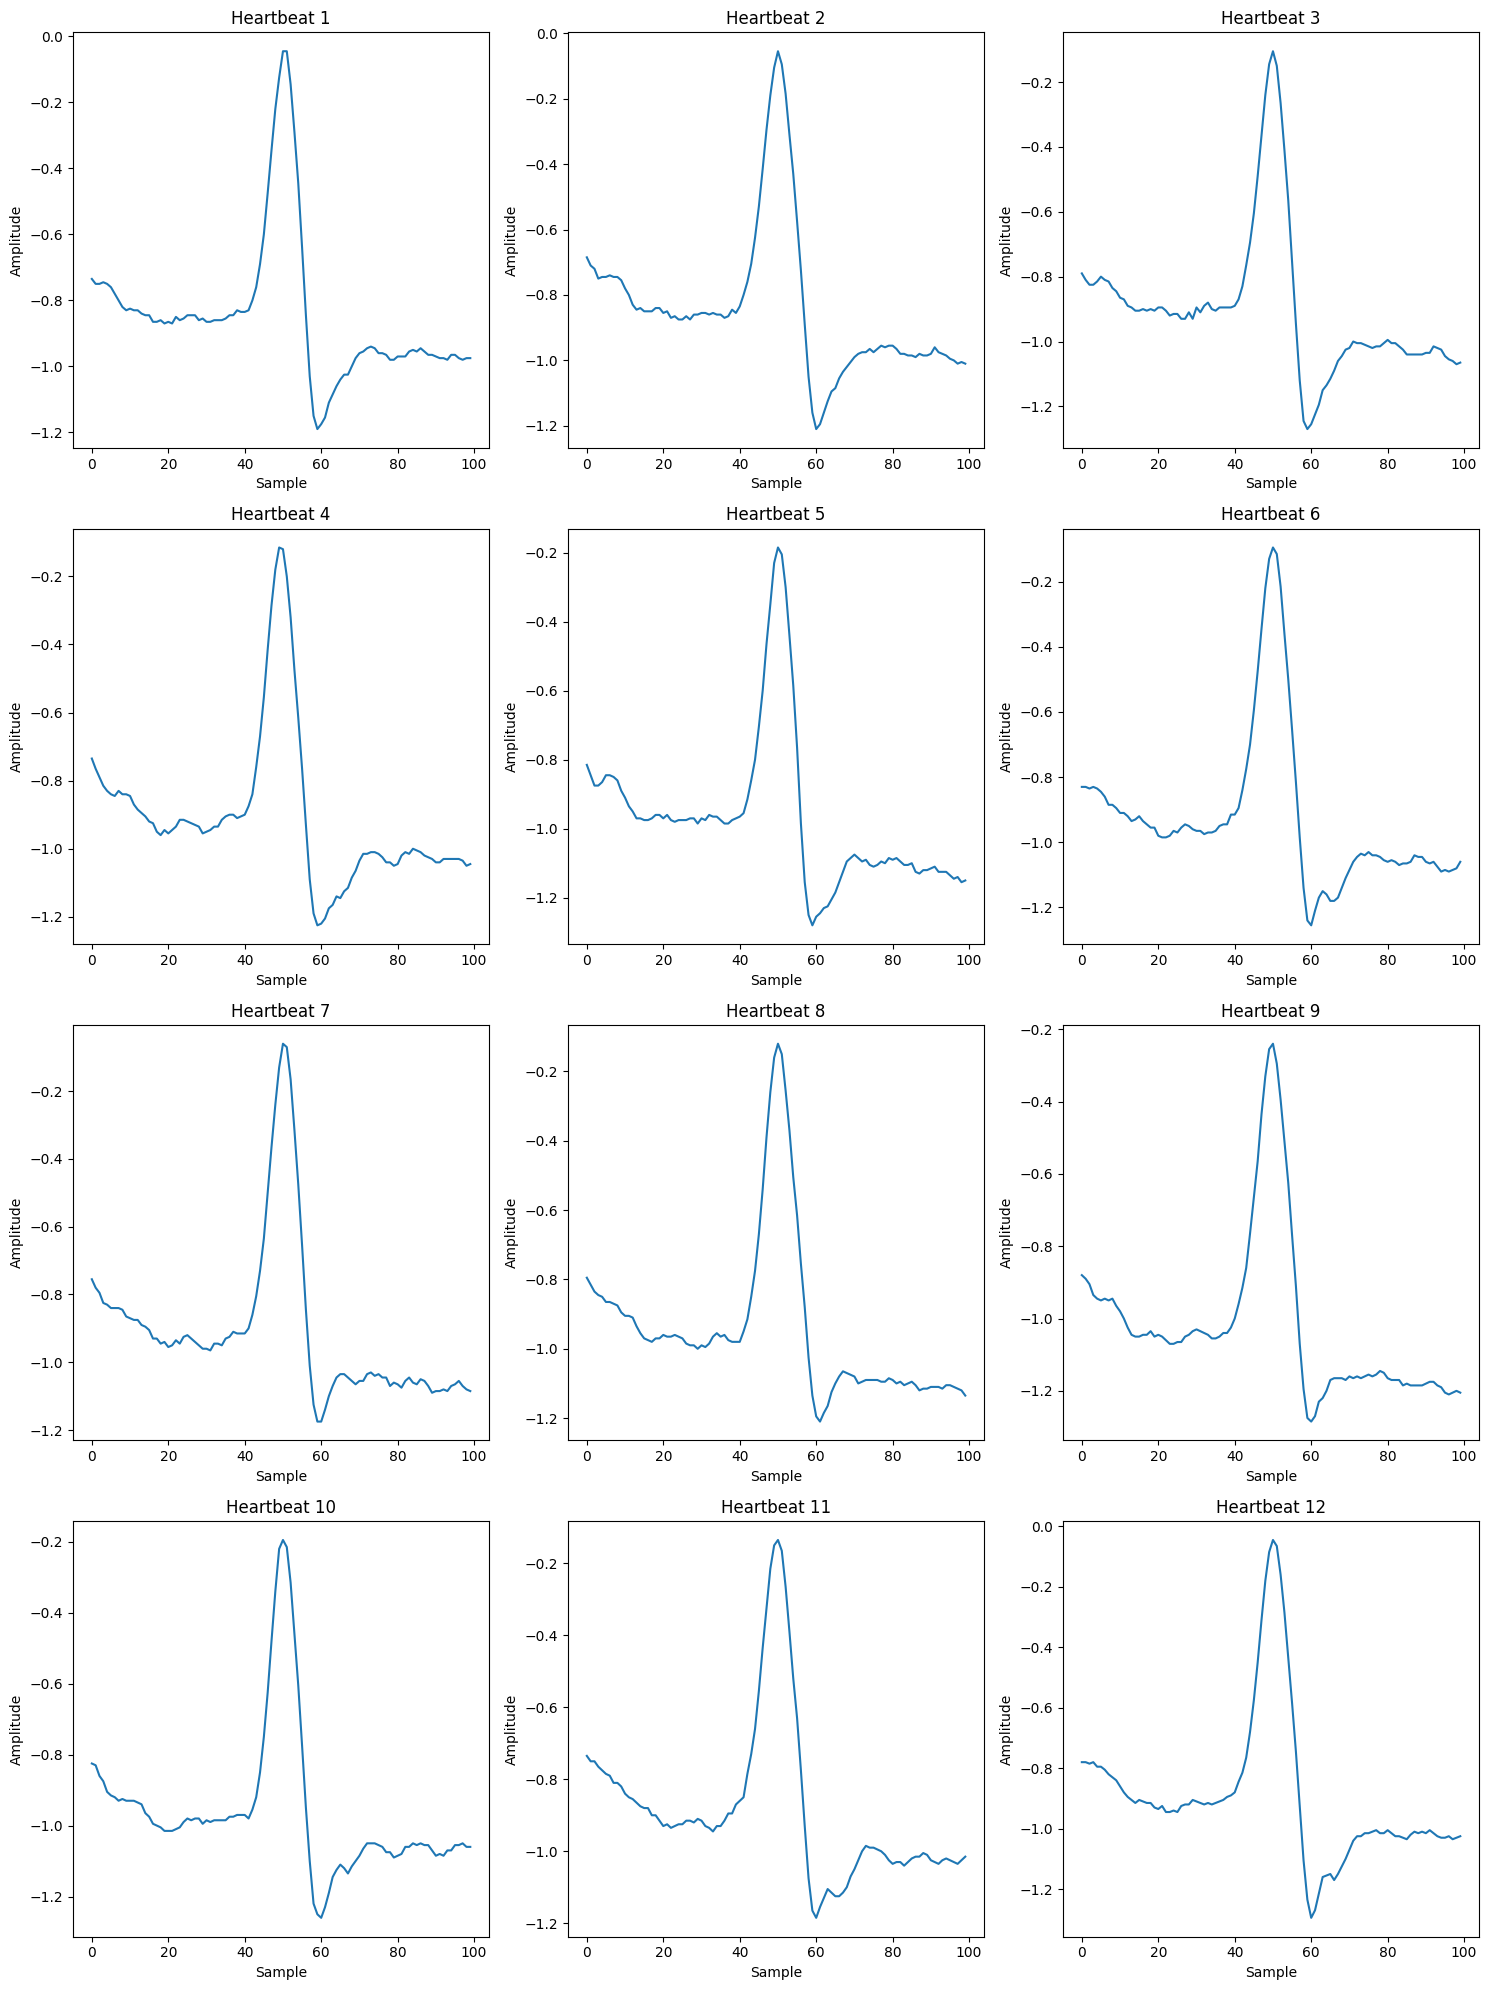

Duration: 8.33 seconds
Average duration of a heartbeat: 0.70 seconds


In [158]:
# Load the ECG signal
# path_102 = "data/ardb/112"
path_102 = "data/ardb/112"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Segment the signal around QRS complexes
window_size = 100  # Define the window size around each QRS complex
heartbeats = []
for qrs_index in xqrs.qrs_inds:
    start_index = max(0, qrs_index - window_size // 2)
    end_index = min(len(sig), qrs_index + window_size // 2)
    heartbeat = sig[start_index:end_index]
    heartbeats.append(heartbeat)

sig = heartbeats[1]

# Plot the individual heartbeats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, heartbeat in enumerate(heartbeats):
    plt.plot(heartbeat, label=f"Heartbeat {i+1}")

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Individual Heartbeats')
plt.legend()
plt.show()

# Plot the individual heartbeats in separate subplots
num_beats = len(heartbeats)
num_cols = 3  # Define the number of columns for subplots
num_rows = (num_beats + num_cols - 1) // num_cols  # Calculate the number of rows

plt.figure(figsize=(15, 5*num_rows))
for i, heartbeat in enumerate(heartbeats):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(heartbeat)
    plt.title(f"Heartbeat {i+1}")
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Duration
sampling_frequency = 360
num_samples = 3000
duration = num_samples / sampling_frequency

print(f"Duration: {duration:.2f} seconds")

# Calculate the intervals between consecutive QRS complexes
qrs_intervals = np.diff(xqrs.qrs_inds) / fields['fs']  # Convert samples to seconds

# Calculate the average duration of a heartbeat
avg_heartbeat_duration = np.mean(qrs_intervals)

print(f"Average duration of a heartbeat: {avg_heartbeat_duration:.2f} seconds")

#### Generate Spectograms and Scalograms

For the scalogram, inspiration was taken from: https://de.mathworks.com/help/wavelet/ug/classify-time-series-using-wavelet-analysis-and-deep-learning.html


C:\Users\Pie\AppData\Local\Temp\ipykernel_9468\4143857142.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 40)


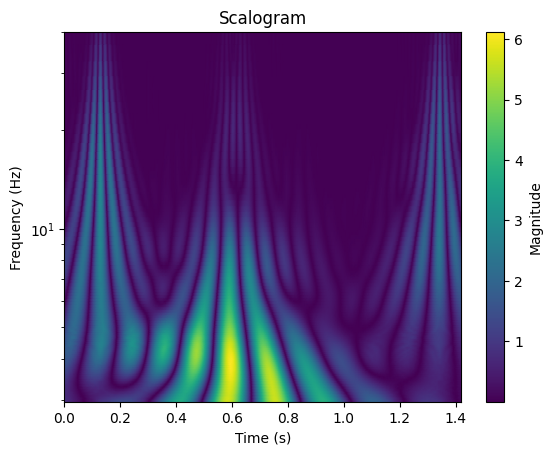

In [252]:
# Load record
samples = 128*4
Fs=360
record = wfdb.rdsamp('data/ardb/208', sampto=samples)   # extract first 720 samples
I = record[0][:, 0]                                     # extract first lead

# INPUT = single-lead ECG signal
# OUTPUT = visualizes scalogram   
def plot_scalogram(I,Fs,samples):
    scales = np.arange(1, 100)
    cwt_result, frq = pywt.cwt(I, scales, 'morl', sampling_period=1/Fs)

    # Plot the scalogram
    t = np.arange(samples) / Fs
    plt.pcolormesh(t, frq, np.abs(cwt_result), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Scalogram')
    plt.colorbar(label='Magnitude')

    # Set y-axis scale to logarithmic
    plt.yscale('log')

    # Set y-axis limits to show only the range between 0 and 200 Hz
    plt.ylim(0, 40)  

    plt.show()

def plot_multiple_scalograms(signals, Fs_values, names):
    num_signals = len(signals)
    samples = len(signals[0])

    plt.figure(figsize=(5 * num_signals, 5))

    for i, (signal, Fs, name) in enumerate(zip(signals, Fs_values, names), 1):
        scales = np.arange(1, 100)
        cwt_result, frq = pywt.cwt(signal, scales, 'morl', sampling_period=1/Fs)

        # Plot the scalogram
        t = np.arange(samples) / Fs
        plt.subplot(1, num_signals, i)
        plt.pcolormesh(t, frq, np.abs(cwt_result), shading='gouraud')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (s)')
        plt.title(name + ' Scalogram')
        plt.colorbar(label='Magnitude')

        # Set y-axis scale to logarithmic
        plt.yscale('log')

        # Set y-axis limits to show only the range between 0 and 200 Hz
        plt.ylim(0, 40)

    plt.tight_layout()
    plt.show()

plot_scalogram(I,Fs,samples)


The stft we take using pytorch methods. We can learn about the parameters to choose here: https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

This paper used pytrochaudio with STFT and ISTFT to generate synthetic ECG with diffusion models: https://arxiv.org/pdf/2306.01875.pdf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time Series


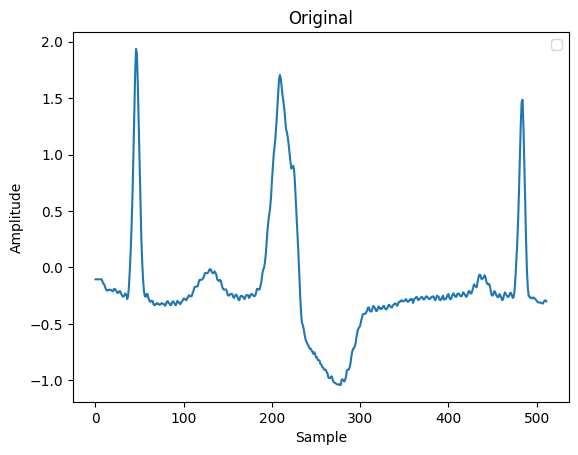

STFT


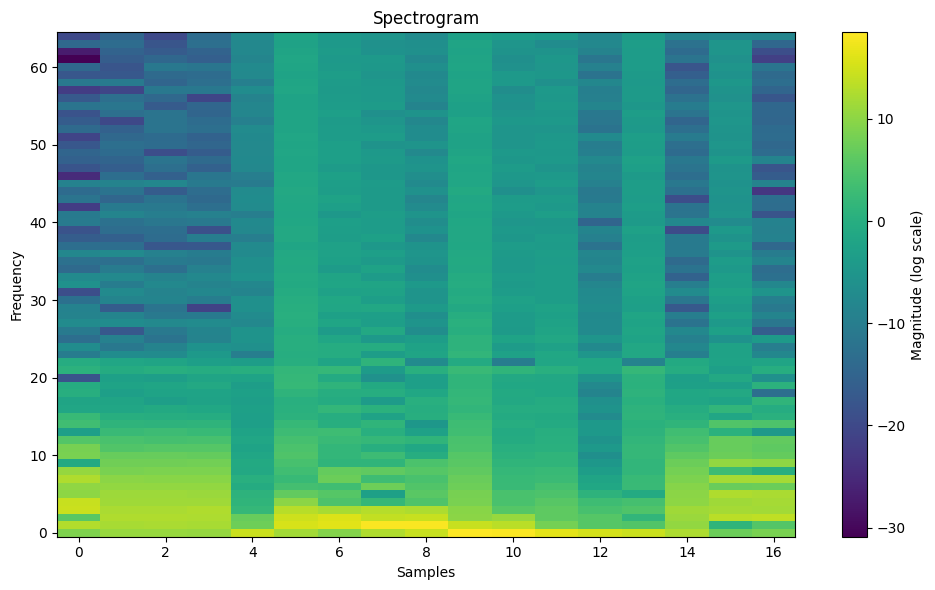

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ISTFT


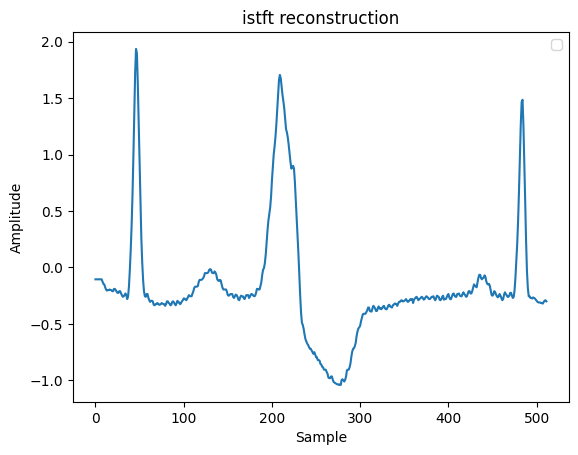

Mean Absolute Error (MAE) between original and reconstructed signal: -2.4377608221978764e-18


In [255]:
def generate_stft(I): 
    # Convert the NumPy array I to a PyTorch tensor
    I_tensor = torch.tensor(I)
    # Compute the STFT
    stft = torch.stft(I_tensor, n_fft=128, center=True, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)    
    return stft

def generate_istft(stft):
    # Compute the ISTFT
    I = torch.istft(stft, n_fft=128, center=True, normalized=False, onesided=True)
    return I

def plot_spectrogram(stft): 
    # Compute the magnitude spectrogram
    magnitude = torch.abs(stft)
    log_magnitude = 10 * np.log10(magnitude)
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(log_magnitude, aspect='auto', origin='lower')
    plt.title('Spectrogram')
    plt.xlabel('Samples')
    plt.ylabel('Frequency')
    plt.colorbar(label='Magnitude (log scale)')
    plt.tight_layout()
    plt.show() 

def plot_multiple_spectrograms(stfts, names):
    num_stfts = len(stfts)
    plt.figure(figsize=(10 * num_stfts, 6))

    for i, (stft, name) in enumerate(zip(stfts, names), 1):
        # Compute the magnitude spectrogram
        magnitude = torch.abs(stft)
        log_magnitude = 10 * np.log10(magnitude)

        # Plot the spectrogram
        plt.subplot(1, num_stfts, i)
        plt.imshow(log_magnitude, aspect='auto', origin='lower')
        plt.title(name + ' Spectrogram')
        plt.xlabel('Samples')
        plt.ylabel('Frequency')
        plt.colorbar(label='Magnitude (log scale)')

    plt.tight_layout()
    plt.show()



def visualize_time_series(I,title='Time Series'):  
    plt.plot(I)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Example
print('Time Series')
visualize_time_series(I, 'Original')
print('STFT')
stft = generate_stft(I)
plot_spectrogram(stft)
print('ISTFT')
istft = generate_istft(stft)
visualize_time_series(istft, 'istft reconstruction')

# Verify if we have a loseless reconstruction
mae = np.mean(np.mean(I - istft.numpy()))
print('Mean Absolute Error (MAE) between original and reconstructed signal:', mae)

#### Encoding Timeseries for Deep Learning
We can use an alternative approach from this paper (https://arxiv.org/pdf/1506.00327.pdf) also used in a paper that used diffusion models to generate ECG signals (https://arxiv.org/pdf/2303.02475.pdf).

Further researched in this paper (https://www.researchgate.net/figure/Conceptual-block-diagram-of-the-proposed-structure-for-individual-household-power_fig4_338359485)

Not investigated: 
- recurrence plots

In [101]:
# taken from paper 'Generating ECG using Diffusion Models'
def rescale_time_series(X):     
    """
    Rescale the time series X to fall within the interval [-1, 1].
    
    Parameters:
    X (array-like): The input time series.
    
    Returns:
    X_rescaled (array-like): The rescaled time series.
    """
    X_min = np.min(X)
    X_max = np.max(X)
    X_rescaled = (X - X_max + (X - X_min)) / (X_max - X_min)
    return X_rescaled

# X=I
# X = rescale_time_series(X)
# print('min',  np.min(X))
# print('max',  np.max(X))

# # Calculate the radius values 'r' using the time stamps
# r = np.arange(1, len(X) + 1) / len(X)

# # Calculate the angular values 'phi' using the rescaled time series
# phi = np.arccos(X)

# # Plot the polar coordinates
# plt.figure(figsize=(8, 8))
# plt.polar(phi, r, marker='o', linestyle='-')
# plt.title('Polar Coordinates of Rescaled Time Series')
# plt.xlabel('Angular Values (phi)')
# plt.ylabel('Radius (r)')
# plt.grid(True)
# plt.show()

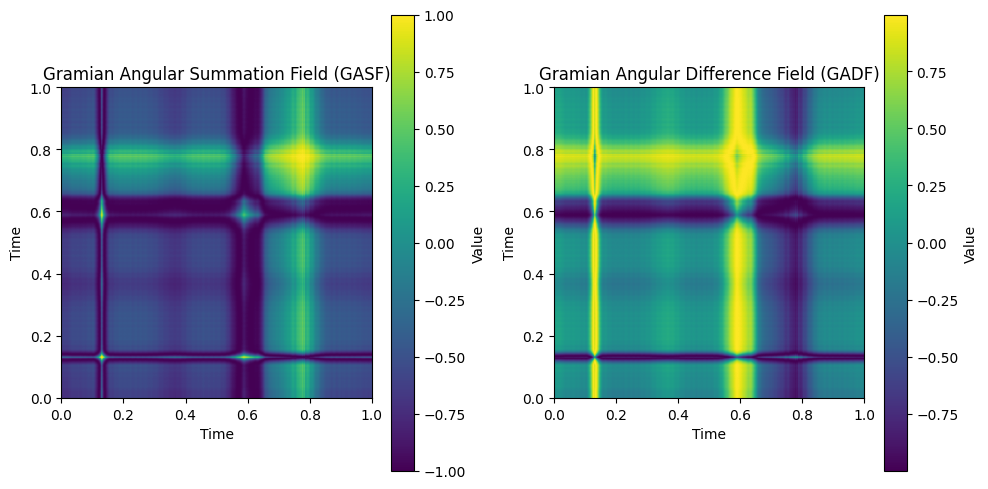

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField

# Right format to use GramianAngularField
X = np.array([I])

# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)

# Plot the GASF
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_gasf[0], origin='lower', extent=[0, len(X), 0, len(X)])
plt.title('Gramian Angular Summation Field (GASF)')
plt.xlabel('Time')
plt.ylabel('Time')
plt.colorbar(label='Value')

# Plot the GADF
plt.subplot(1, 2, 2)
plt.imshow(X_gadf[0], origin='lower', extent=[0, len(X), 0, len(X)])
plt.title('Gramian Angular Difference Field (GADF)')
plt.xlabel('Time')
plt.ylabel('Time')
plt.colorbar(label='Value')

plt.tight_layout()
plt.show()


(1, 356, 356)


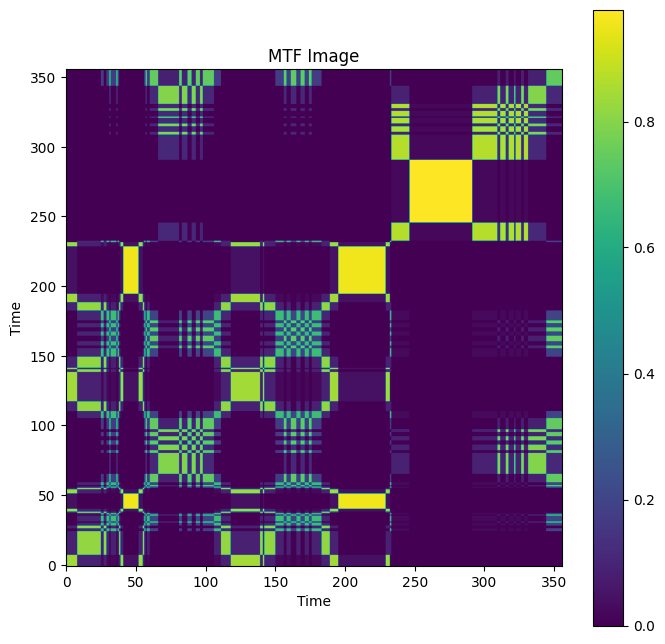

In [12]:
from pyts.image import MarkovTransitionField

transformer = MarkovTransitionField()
X_new = transformer.transform(X)
X_new.shape

print(X_new.shape)

X_mtf = X_new

# Visualize MTF
plt.figure(figsize=(8, 8))
plt.imshow(X_new[0], origin='lower')
plt.title('MTF Image')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()

In [244]:
from sklearn.preprocessing import MinMaxScaler
from pyts.image import GramianAngularField, MarkovTransitionField

# # Combine the techniques to convert 1D ECG into 2D Embedding (image) - 
# #   - INPUT=1D time series (one lead)
# #   - OUTPUT=2D embedding of summated GASF, GADF, MTF
def embed_ECG(X):
    # rescale 
    X = X.reshape(1, -1)
    X = rescale_time_series(X)
    # print('Shape of X...')
    # print(X.shape)
    
    # Compute Gramian angular fields
    gasf = GramianAngularField(method='summation')
    X_gasf = gasf.transform(X)
    # print('gasf shape',  X_gasf.shape)
    # print('gasf min',np.min(X_gasf) )
    # print('gasf max',np.max(X_gasf) )

    gadf = GramianAngularField(method='difference')
    X_gadf = gadf.transform(X)
    # print('gadf shape',  X_gadf.shape)
    # print('gadf min',np.min(X_gadf) )
    # print('gadf max',np.max(X_gadf) )

    # Compute Markov Transition Field
    transformer = MarkovTransitionField()
    X_mtf = transformer.transform(X)    
    # print('mtf shape',  X_mtf.shape)
    # print('mtf min',np.min(X_mtf) )
    # print('mtf max',np.max(X_mtf) )

    # Combine the three matrices along the last axis
    return np.stack((X_gasf[0], X_gadf[0], X_mtf[0]), axis=-1)
    # return np.stack((X_gasf[0], X_gadf[0], np.zeros(X_gadf[0].shape)), axis=-1)

def extract_1D(X):
    return X[:, :, 0]

# def plot_2D_embedding(ecg_2D,title='ECG 2D'):
#     plt.imshow(ecg_2D)
#     plt.title(title)
#     plt.xlabel('Time')
#     plt.ylabel('Time')
#     plt.show()

def plot_2D_embedding(embeddings, names, title='ECG 2D'):
    num_embeddings = len(embeddings)

    plt.figure(figsize=(5 * num_embeddings, 5))

    for i, (embedding, name) in enumerate(zip(embeddings, names), 1):
        plt.subplot(1, num_embeddings, i)
        plt.imshow(embedding)
        plt.title(name)
        plt.xlabel('Time')
        plt.ylabel('Time')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Let's compare the embedding, stft, scalogram of two different ECGs.

In [240]:
# Example
Fs=360; samples=128*5     
record_1 = wfdb.rdsamp('data/ardb/214', sampto=samples); sig_1 = record_1[0][:, 0]
record_2 = wfdb.rdsamp('data/ardb/231', sampto=samples); sig_2 = record_2[0][:, 0]

# 2D Embeddings
# plot_2D_embedding(embed_ECG(sig_1))
# plot_2D_embedding(embed_ECG(sig_2))

# # Scalogram
# plot_scalogram(sig_1,Fs,samples)
# plot_scalogram(sig_2,Fs,samples)

# # Spectogram
# plot_spectrogram(stft=generate_stft(sig_1))
# plot_spectrogram(stft=generate_stft(sig_2))

#### Build noisy samples

Since our goal is to use a supervised diffusion 'image restauration' model... We need to build a training/test set.

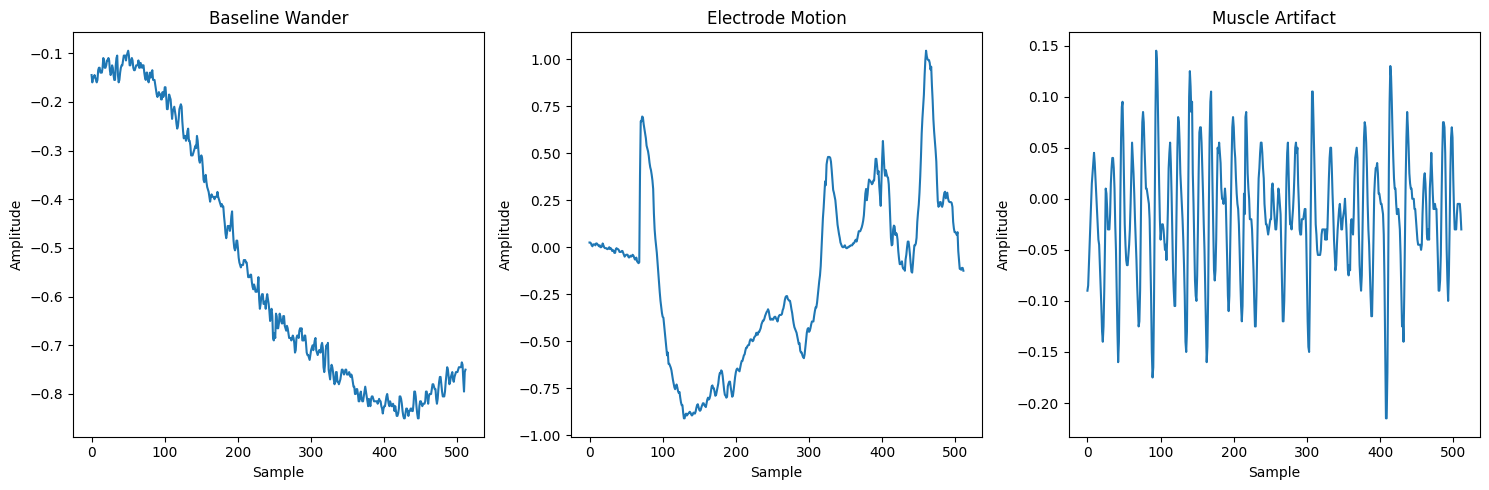

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


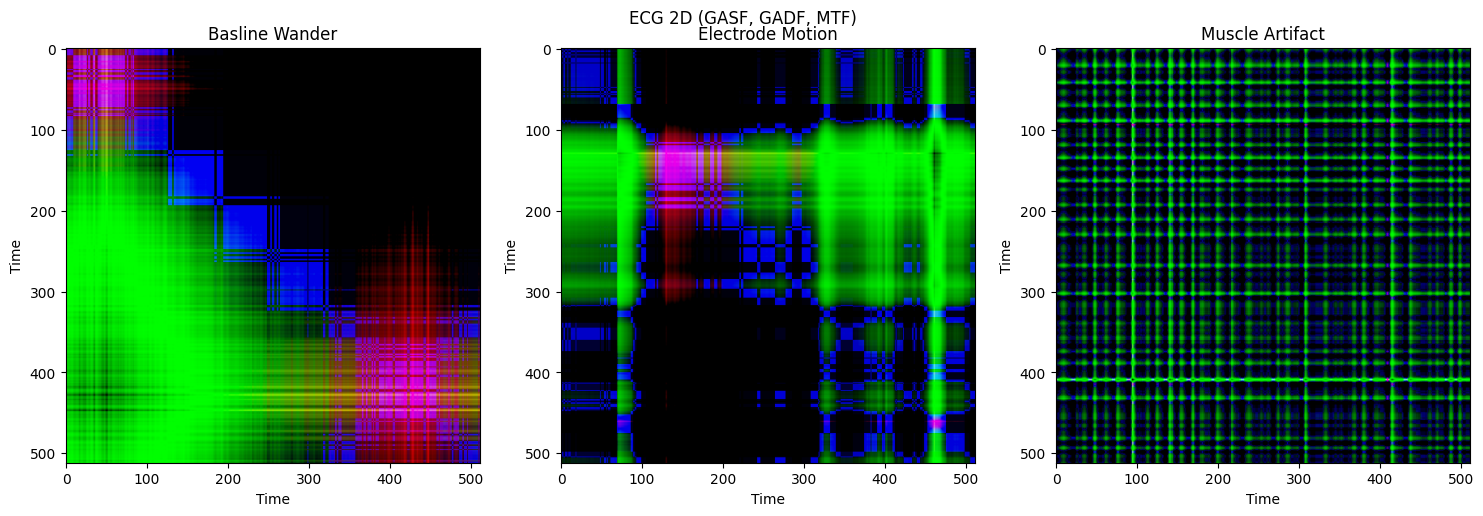

C:\Users\Pie\AppData\Local\Temp\ipykernel_9468\4143857142.py:52: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 40)


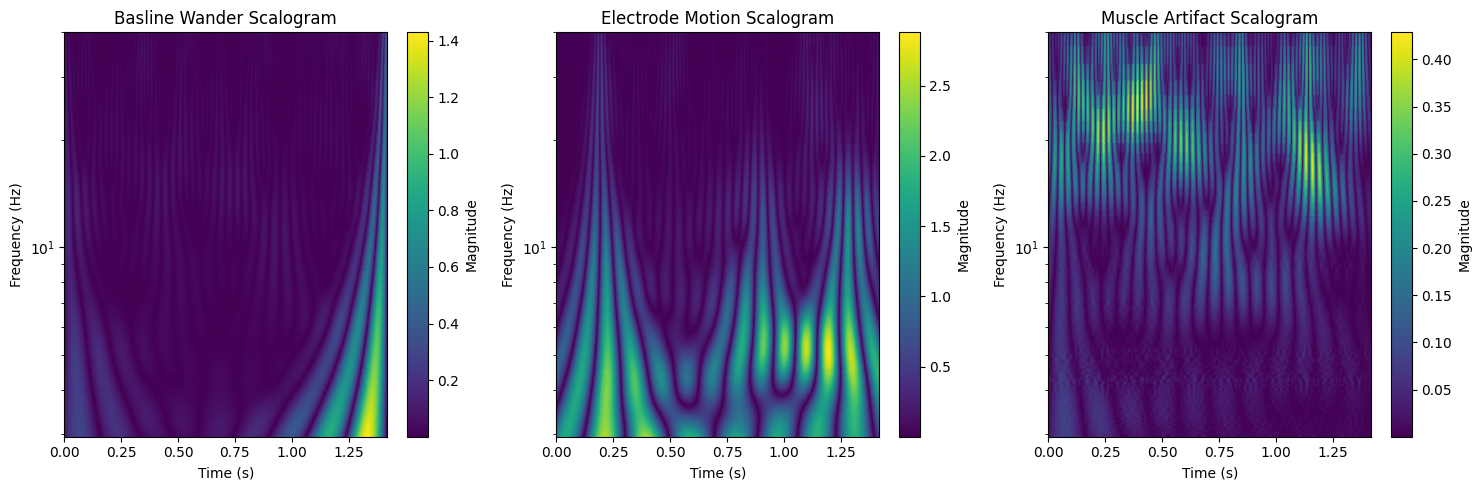

C:\Users\Pie\AppData\Local\Temp\ipykernel_9468\1908378196.py:34: RuntimeWarning: divide by zero encountered in log10
  log_magnitude = 10 * np.log10(magnitude)


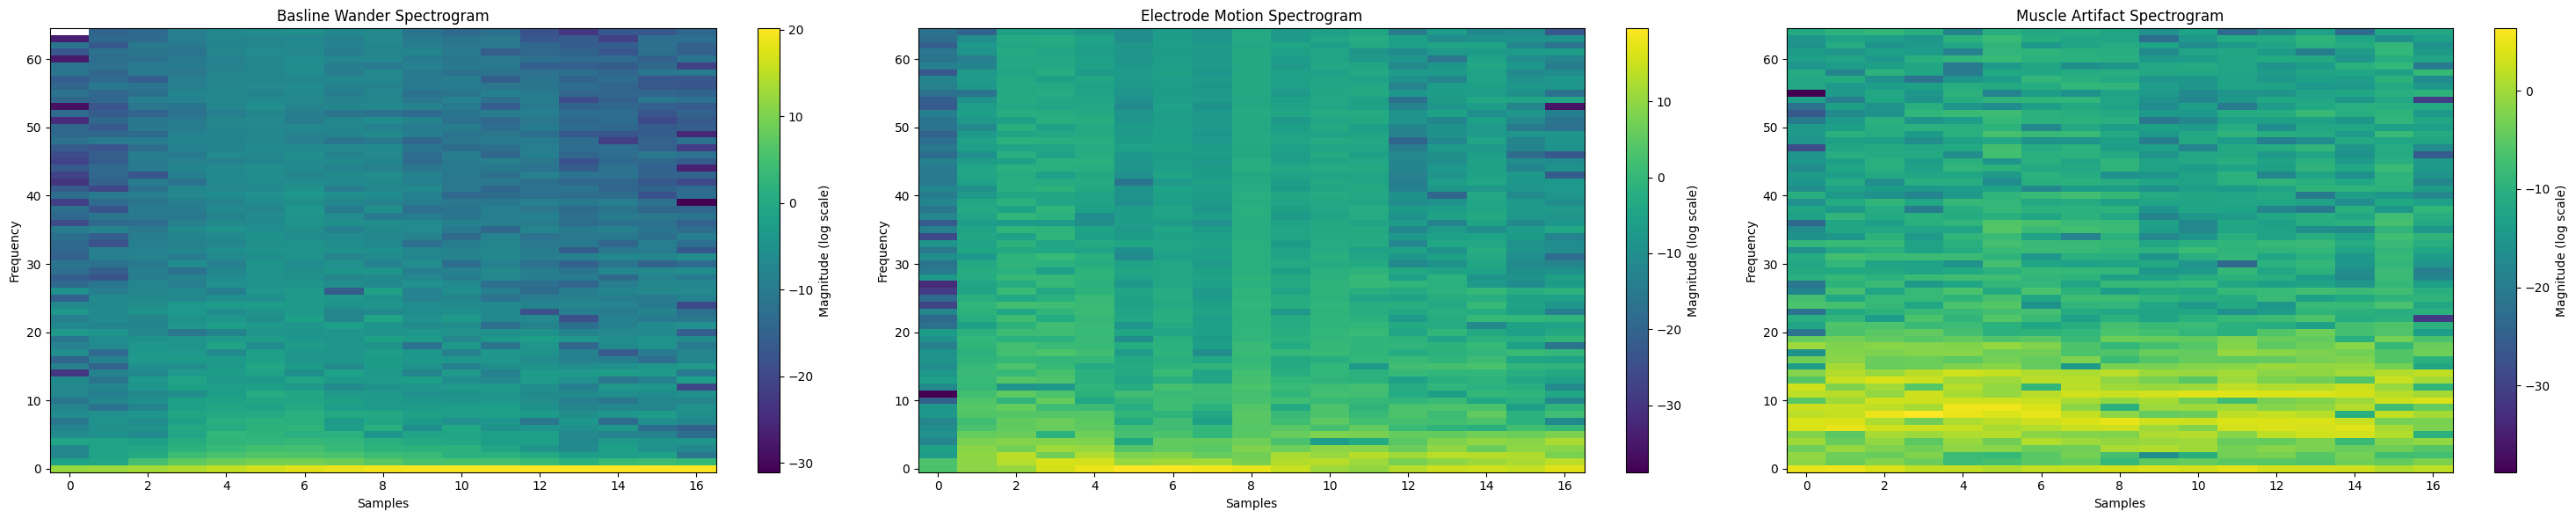

In [256]:
# Extract record
sampto=128*2*2
record_bw = wfdb.rdsamp("data/nstdb/bw", sampto=sampto); signal_bw = record_bw[0][:, 0] 
record_em = wfdb.rdsamp("data/nstdb/em", sampto=sampto); signal_em = record_em[0][:, 0]
record_ma = wfdb.rdsamp("data/nstdb/ma", sampto=sampto); signal_ma = record_ma[0][:, 0]



# Plot multiple 2D Embeddings
embed_ECGs = [embed_ECG(signal_bw), embed_ECG(signal_em), embed_ECG(signal_ma) ]
names = ['Basline Wander', 'Electrode Motion', 'Muscle Artifact']
plot_2D_embedding(embed_ECGs, names, title='ECG 2D (GASF, GADF, MTF)')

# Plot Multiple Scalograms
plot_multiple_scalograms([signal_bw,signal_em,signal_ma], [360,360,360], names)

# Plot Multiple Spectograms
stft_ECGs = [generate_stft(signal_bw), generate_stft(signal_em), generate_stft(signal_ma)]
plot_multiple_spectrograms(stft_ECGs,  names)

#### Build Training- and Test Set
Now we will build a larger training set. At this point only from MIT-BIH Arrythmia, similar to (https://arxiv.org/pdf/2306.01875.pdf) - however we can later include a lot more data... and then we can potentially start using larger window, cause we have more data!

Let us do the following: 
- step 1 : generate synthetic heartbeats using latent flow matching 
- step 2 : adapt this strategy to denoise ECG signals : use supervised IR DM